# End To End Demo

This notebooks demonstrates the data flow of generating a graph from a CSV file using Runway v0.12.0

In [1]:
import os

from dotenv import load_dotenv

from neo4j_runway import Discovery, GraphDataModeler, PyIngest
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.utils import test_database_connection
from neo4j_runway.utils.data import load_local_files

load_dotenv()

True

## Load and Describe Data

We may use `load_local_files` to easily prepare our csv file for Runway. Below we define the `data_directory`, `data_dictionary` and `use_cases` which will assist the LLM in the Discovery process.

In [2]:
data_directory = "../../../data/countries/"

data_dictionary = {
                    'id': 'unique id for a country.',
                'name': 'the country name.',
                'phone_code': 'country area code.',
                'capital': 'the capital of the country.',
                'currency_name': "name of the country's currency.",
                'region': 'primary region of the country.',
                'subregion': 'subregion location of the country.',
                'timezones': 'timezones contained within the country borders.',
                'latitude': 'the latitude coordinate of the country center.',
                'longitude': 'the longitude coordinate of the country center.'
                }

use_cases = [
        "Which region contains the most subregions?", 
        "What currencies are most popular?", 
        "Which countries share timezones?"
    ]

In [4]:
data = load_local_files(data_directory=data_directory, 
                        data_dictionary=data_dictionary, 
                        general_description="This is data on countries and their attributes.",
                        use_cases=use_cases, 
                        include_files=["countries.csv"])

### Preview Data Contents

In [5]:
data.tables[0].dataframe.head()

,id,name,phone_code,capital,currency_name,region,subregion,timezones,latitude,longitude
0,1,Afghanistan,93,Kabul,Afghan afghani,Asia,Southern Asia,"[{zoneName:'Asia\/Kabul',gmtOffset:16200,gmtOf...",33.000000,65.0
1,2,Aland Islands,+358-18,Mariehamn,Euro,Europe,Northern Europe,"[{zoneName:'Europe\/Mariehamn',gmtOffset:7200,...",60.116667,19.9
2,3,Albania,355,Tirana,Albanian lek,Europe,Southern Europe,"[{zoneName:'Europe\/Tirane',gmtOffset:3600,gmt...",41.000000,20.0
3,4,Algeria,213,Algiers,Algerian dinar,Africa,Northern Africa,"[{zoneName:'Africa\/Algiers',gmtOffset:3600,gm...",28.000000,3.0
4,5,American Samoa,+1-684,Pago Pago,US Dollar,Oceania,Polynesia,"[{zoneName:'Pacific\/Pago_Pago',gmtOffset:-396...",-14.333333,-170.0


## Initialize LLMs

We now initialize the LLMs to use in data discovery and data model creation.

In [6]:
llm_disc = OpenAIDiscoveryLLM(model_name='gpt-4o-mini-2024-07-18', model_params={"temperature": 0})
llm_dm = OpenAIDataModelingLLM(model_name='gpt-4o-2024-05-13', model_params={"temperature": 0.5})

## Discovery

We now load the above data into a Discovery object.

In [7]:
disc = Discovery(llm=llm_disc, data=data)

In [8]:
disc.run(show_result=True, notebook=True)

### Preliminary Analysis of Country Data

#### Overall Data Characteristics:
1. **Data Size**: The dataset contains 250 entries (countries) and 10 attributes.
2. **Data Types**: The attributes include integers, floats, and objects (strings). The presence of both numerical and categorical data allows for diverse analyses.
3. **Missing Values**: 
   - `capital`: 5 missing values (2% of the data)
   - `region`: 2 missing values (0.8% of the data)
   - `subregion`: 3 missing values (1.2% of the data)
   - Other columns have no missing values.

#### Important Features:
1. **id**: Unique identifier for each country. It is uniformly distributed from 1 to 250.
2. **name**: Each country has a unique name, which is crucial for identification.
3. **phone_code**: There are 235 unique phone codes, indicating that some countries share the same code. This could be relevant for understanding regional telecommunications.
4. **capital**: The capital city is a significant attribute, but with 5 missing values, it may require attention during analysis.
5. **currency_name**: There are 161 unique currencies, with the Euro being the most common (35 occurrences). This suggests a potential clustering of countries using the same currency, which could be relevant for economic analyses.
6. **region**: There are 6 unique regions, with Africa having the highest frequency (60 countries). This could indicate a need to explore regional characteristics further.
7. **subregion**: 22 unique subregions exist, with the Caribbean being the most frequent (28 occurrences). This suggests that some regions have more subdivisions than others.
8. **timezones**: The dataset contains 245 unique timezones, indicating that many countries share timezones. This could be useful for understanding global time coordination.

#### Use Case Insights:
1. **Regions and Subregions**: To determine which region contains the most subregions, we can analyze the `region` and `subregion` columns. The region with the highest number of unique subregions will be identified.
2. **Popular Currencies**: The `currency_name` column can be analyzed to find the most frequently occurring currencies, highlighting economic ties between countries.
3. **Shared Timezones**: The `timezones` column can be examined to identify countries that share the same timezone, which may have implications for trade, communication, and travel.

### Conclusion:
The dataset provides a rich source of information about countries, their geographical locations, and economic attributes. The most important features for analysis include `region`, `subregion`, `currency_name`, and `timezones`, as they directly relate to the use cases outlined. Addressing the missing values in `capital`, `region`, and `subregion` will also be essential for a comprehensive analysis.

## Data Modeling

We can now use our Discovery object to provide context to the LLM for data model generation. Notice that we don't need to pass our actual data to the modeler, just insights we've gathered so far. 

In [9]:
gdm = GraphDataModeler(
    llm=llm_dm,
    discovery=disc
)

### The First Data Model

We now generate our first data model.

In [10]:
gdm.create_initial_model(max_retries=3)

> Generating Nodes...
Attempts | 2  
Received Valid Nodes
Nodes
* (:Country)     * (:Region)
* (:Subregion)   * (:Currency)
* (:Timezone)     

> Generating Data Model...
Attempts | 1  
Received Valid Data Model
Nodes
* (:Country)     * (:Region)
* (:Subregion)   * (:Currency)
* (:Timezone)     

Relationships
* (:Country)-[:LOCATED_IN]->(:Region)               
* (:Country)-[:PART_OF]->(:Subregion)               
* (:Country)-[:USES]->(:Currency)                   
* (:Country)-[:SHARES_TIMEZONE_WITH]->(:Timezone)   
* (:Region)-[:HAS_SUBREGION]->(:Subregion)          


DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='int', column_mapping='phone_code', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', column_mapping='latitude', alias=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', column_mapping='longitude', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='Region', properties=[Property(name='name', type='str', column_mapping='region', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Subregion', properties=[Property(name='name', type='str', column_mapping='subregion

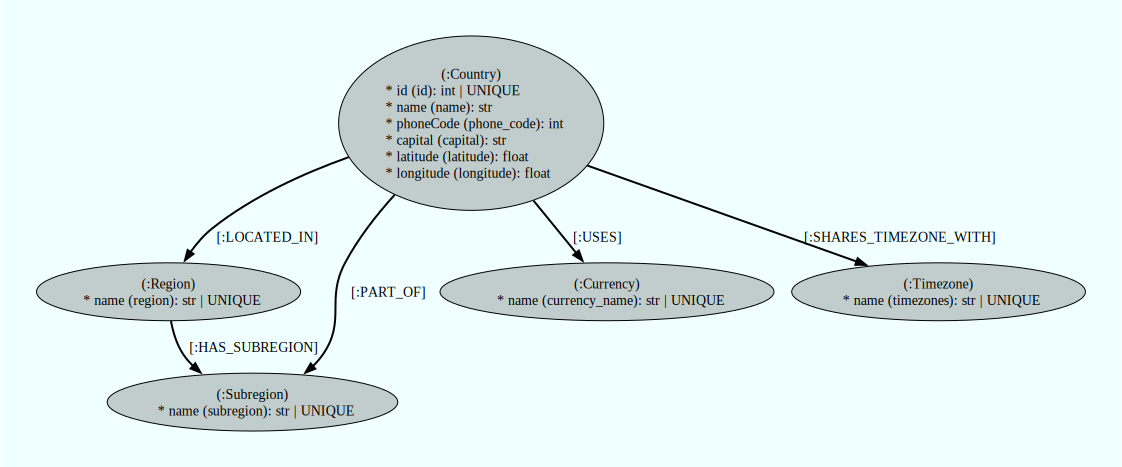

In [11]:
gdm.current_model.visualize()

Our data model seems to address the three use cases we'd like answered:
* Which region contains the most subregions?
* What currencies are most popular?
* Which countries share timezones?

### Modifying A Data Model

If we would like the data model modified, we may request the LLM to make changes.

In [12]:
corrections = "Create a Capital node from the capital property."

gdm.iterate_model(corrections=corrections)

> Generating Data Model...
Attempts | 1  
Received Valid Data Model
Nodes
* (:Country)     * (:Region)
* (:Subregion)   * (:Currency)
* (:Timezone)    * (:Capital) 

Relationships
* (:Country)-[:LOCATED_IN]->(:Region)               
* (:Country)-[:PART_OF]->(:Subregion)               
* (:Country)-[:USES]->(:Currency)                   
* (:Country)-[:SHARES_TIMEZONE_WITH]->(:Timezone)   
* (:Region)-[:HAS_SUBREGION]->(:Subregion)          
* (:Country)-[:HAS_CAPITAL]->(:Capital)             


DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='int', column_mapping='phone_code', alias=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', column_mapping='latitude', alias=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', column_mapping='longitude', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='Region', properties=[Property(name='name', type='str', column_mapping='region', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Subregion', properties=[Property(name='name', type='str', column_mapping='subregion', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Currency', properties=[Prop

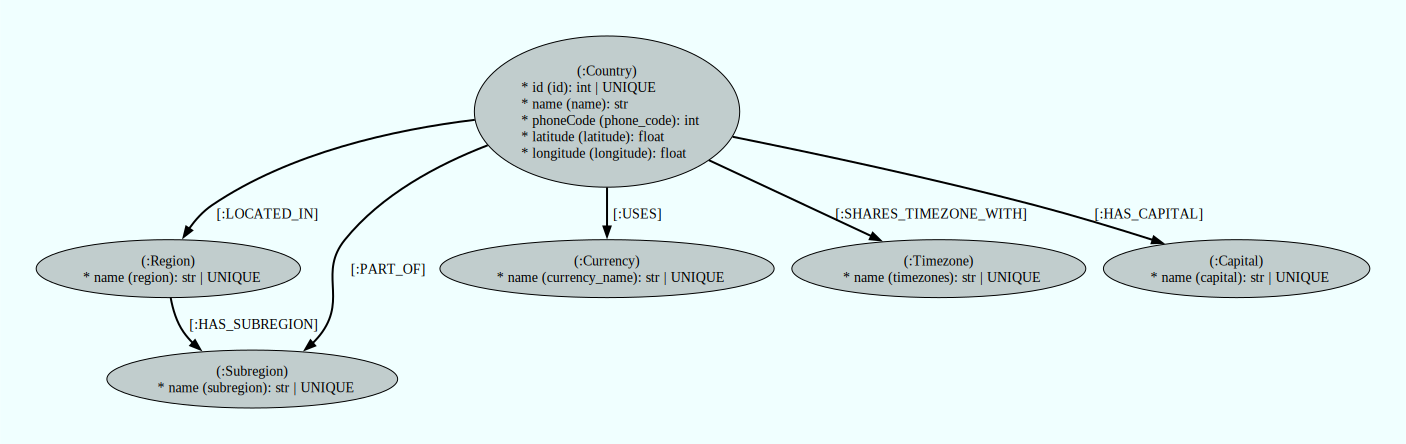

In [13]:
gdm.current_model.visualize()

We can now create some ingestion code to get our data into our database.

## Ingestion Code Generation

We can provide our credentials here in this step if we plan on using PyIngest to load our data. This will inject our credentials into the generated YAML file. If we leave the credential fields blank, then we can just fill in the blanks in the generated YAML file later.

In [18]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, 
                         username=os.environ.get("NEO4J_USERNAME"), 
                         password=os.environ.get("NEO4J_PASSWORD"), 
                         uri=os.environ.get("NEO4J_URI"), 
                         database=os.environ.get("NEO4J_DATABASE"), 
                         file_directory=data_directory, source_name="countries.csv")

In [19]:
pyingest_yaml = gen.generate_config_string()
print(pyingest_yaml)

server_uri: bolt://localhost:7687
admin_user: neo4j
admin_pass: password
database: neo4j
basepath: ./

pre_ingest:
  - CREATE CONSTRAINT country_id IF NOT EXISTS FOR (n:Country) REQUIRE n.id IS UNIQUE;
  - CREATE CONSTRAINT region_name IF NOT EXISTS FOR (n:Region) REQUIRE n.name IS UNIQUE;
  - CREATE CONSTRAINT subregion_name IF NOT EXISTS FOR (n:Subregion) REQUIRE n.name IS UNIQUE;
  - CREATE CONSTRAINT currency_name IF NOT EXISTS FOR (n:Currency) REQUIRE n.name IS UNIQUE;
  - CREATE CONSTRAINT timezone_name IF NOT EXISTS FOR (n:Timezone) REQUIRE n.name IS UNIQUE;
  - CREATE CONSTRAINT capital_name IF NOT EXISTS FOR (n:Capital) REQUIRE n.name IS UNIQUE;
files:
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:Country {id: toIntegerOrNull(row.id)})
    SET n.name = row.name, n.phoneCode = toIntegerOrNull(row.phone_code), n.latitude = toFloatOrNull(row.latitude), n.longitude = toFloatOrNull(row.longitude)
  url: $BASE/../../../data/countries/cou

## Ingest Data

We can use the generated yaml string above to orchestrate the data loading via a Runway's PyIngest function. First let's confirm our connection though.

In [20]:
test_database_connection(credentials={"username": os.environ.get("NEO4J_USERNAME"), 
                                      "password": os.environ.get("NEO4J_PASSWORD"), 
                                      "uri": os.environ.get("NEO4J_URI")})

{'valid': True, 'message': 'Connection and Auth Verified!'}

In [21]:
PyIngest(config=pyingest_yaml, verbose=False)

If we check our database we can see that we've ingested our CSV according to the data model we've created!

![countries-single-0.12.0.png](../../../images/countries-single-0.12.0.png)